<a href="https://colab.research.google.com/github/toruuno/DNN_d1d2/blob/master/1_4_1_mnist_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [20]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')
sys.path.append('/content/drive/My Drive/common')
sys.path.append('/content/drive/My Drive/data')
sys.path.append('/content/drive/My Drive')

In [21]:
import numpy as np
from data.mnist import load_mnist
import pickle
from common import functions
import matplotlib.pyplot as plt

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01 # 変更してみよう
#入力層サイズ
input_layer_size = 784 # 変更してみよう
#中間層サイズ
hidden_layer_size = 40 # 変更してみよう
#出力層サイズ
output_layer_size = 10 # 変更してみよう
# 繰り返し数
iters_num = 1000 # 変更してみよう
# ミニバッチサイズ
batch_size = 100 # 変更してみよ
# 学習率
learning_rate = 0.1 # 変更してみよう
# 描写頻度
plot_interval=10

データ読み込み完了


# minst

In [22]:
# 初期設定
def init_network(mode=0):
    network = {} 

    if mode == 0:
      network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_size)
      network['W2'] = wieght_init * np.random.randn(hidden_layer_size, output_layer_size)
    elif mode == 1:
      # 試してみよう_Xavierの初期値
      network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size)
      network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size)
    elif mode == 2:
      # 試してみよう Heの初期値
      network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size) * np.sqrt(2)
      network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)
    else:
      return None  #未定義は故意にError誘導する

    network['b1'] = np.zeros(hidden_layer_size)
    network['b2'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2 = network['W1'], network['W2']
    b1, b2  = network['b1'], network['b2']
        
    u1 =  np.dot(x, W1) + b1
    z1 = functions.relu(u1)
    u2 =  np.dot(z1, W2) + b2
    y = functions.softmax(u2)
 
    return z1, y

# 誤差逆伝播
def backward(x, d, z1, y, network):
    grad = {}
    
    W1, W2 = network['W1'], network['W2']
    b1, b2 = network['b1'], network['b2']    
    # 出力層でのデルタ
    delta2 = functions.d_softmax_with_loss(d, y)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * functions.d_relu(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# 正答率
def accuracy(x, d, network):
    z1, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

def mnist(mode=0):

    # パラメータの初期化
    network = init_network(mode)
    accuracies_train = []
    accuracies_test = []

    for i in range(iters_num):
        # ランダムにバッチを取得    
        batch_mask = np.random.choice(train_size, batch_size)
        # ミニバッチに対応する教師訓練画像データを取得    
        x_batch = x_train[batch_mask]
        # ミニバッチに対応する訓練正解ラベルデータを取得する
        d_batch = d_train[batch_mask]
        
        z1, y = forward(network, x_batch)
        grad = backward(x_batch, d_batch, z1, y, network)

        if (i+1)%plot_interval==0:
            accr_test = accuracy(x_test, d_test, network)
            accuracies_test.append(accr_test)
            
            accr_train = accuracy(x_batch, d_batch, network)
            accuracies_train.append(accr_train)

            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

        # パラメータに勾配適用
        for key in ('W1', 'W2', 'b1', 'b2'):
            network[key]  -= learning_rate * grad[key]


    lists = range(0, iters_num, plot_interval)
    plt.plot(lists, accuracies_train, label="training set")
    plt.plot(lists, accuracies_test,  label="test set")
    plt.legend(loc="lower right")
    plt.title("accuracy")   #日本語表示はgoogle colab上では少々面倒なので英語に変更しておく
    # グラフの表示
    plt.show()

# 「試してみよう」のその１としてネットワークの初期化を３通り変更してみた
# 収束具合はほぼ92%の確率に収束、学習初期の振る舞いが少々変動
# (この場合、初期値が大きくバラける方向の方が初手の学習進度が良さげ)
#、という見え方

Generation: 10. 正答率(トレーニング) = 0.17
                : 10. 正答率(テスト) = 0.1971
Generation: 20. 正答率(トレーニング) = 0.33
                : 20. 正答率(テスト) = 0.2978
Generation: 30. 正答率(トレーニング) = 0.24
                : 30. 正答率(テスト) = 0.2623
Generation: 40. 正答率(トレーニング) = 0.35
                : 40. 正答率(テスト) = 0.3156
Generation: 50. 正答率(トレーニング) = 0.31
                : 50. 正答率(テスト) = 0.2974
Generation: 60. 正答率(トレーニング) = 0.25
                : 60. 正答率(テスト) = 0.3979
Generation: 70. 正答率(トレーニング) = 0.38
                : 70. 正答率(テスト) = 0.4423
Generation: 80. 正答率(トレーニング) = 0.65
                : 80. 正答率(テスト) = 0.6414
Generation: 90. 正答率(トレーニング) = 0.65
                : 90. 正答率(テスト) = 0.624
Generation: 100. 正答率(トレーニング) = 0.66
                : 100. 正答率(テスト) = 0.6884
Generation: 110. 正答率(トレーニング) = 0.69
                : 110. 正答率(テスト) = 0.7336
Generation: 120. 正答率(トレーニング) = 0.71
                : 120. 正答率(テスト) = 0.7195
Generation: 130. 正答率(トレーニング) = 0.76
                : 130. 正答率(テスト) = 0.7805
Generation: 140. 正

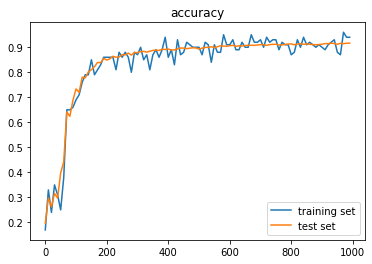

In [23]:
mnist(mode=0)

Generation: 10. 正答率(トレーニング) = 0.5
                : 10. 正答率(テスト) = 0.4781
Generation: 20. 正答率(トレーニング) = 0.61
                : 20. 正答率(テスト) = 0.6702
Generation: 30. 正答率(トレーニング) = 0.79
                : 30. 正答率(テスト) = 0.7919
Generation: 40. 正答率(トレーニング) = 0.79
                : 40. 正答率(テスト) = 0.7992
Generation: 50. 正答率(トレーニング) = 0.8
                : 50. 正答率(テスト) = 0.8271
Generation: 60. 正答率(トレーニング) = 0.84
                : 60. 正答率(テスト) = 0.85
Generation: 70. 正答率(トレーニング) = 0.85
                : 70. 正答率(テスト) = 0.8668
Generation: 80. 正答率(トレーニング) = 0.86
                : 80. 正答率(テスト) = 0.8629
Generation: 90. 正答率(トレーニング) = 0.85
                : 90. 正答率(テスト) = 0.8731
Generation: 100. 正答率(トレーニング) = 0.89
                : 100. 正答率(テスト) = 0.8752
Generation: 110. 正答率(トレーニング) = 0.87
                : 110. 正答率(テスト) = 0.8759
Generation: 120. 正答率(トレーニング) = 0.87
                : 120. 正答率(テスト) = 0.884
Generation: 130. 正答率(トレーニング) = 0.9
                : 130. 正答率(テスト) = 0.8858
Generation: 140. 正答率(トレ

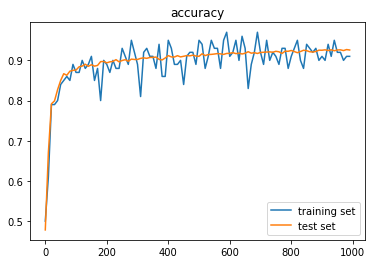

In [24]:
mnist(mode=1)

Generation: 10. 正答率(トレーニング) = 0.58
                : 10. 正答率(テスト) = 0.5771
Generation: 20. 正答率(トレーニング) = 0.67
                : 20. 正答率(テスト) = 0.7206
Generation: 30. 正答率(トレーニング) = 0.7
                : 30. 正答率(テスト) = 0.7828
Generation: 40. 正答率(トレーニング) = 0.81
                : 40. 正答率(テスト) = 0.8296
Generation: 50. 正答率(トレーニング) = 0.92
                : 50. 正答率(テスト) = 0.8416
Generation: 60. 正答率(トレーニング) = 0.76
                : 60. 正答率(テスト) = 0.8525
Generation: 70. 正答率(トレーニング) = 0.9
                : 70. 正答率(テスト) = 0.8465
Generation: 80. 正答率(トレーニング) = 0.82
                : 80. 正答率(テスト) = 0.8634
Generation: 90. 正答率(トレーニング) = 0.84
                : 90. 正答率(テスト) = 0.8642
Generation: 100. 正答率(トレーニング) = 0.86
                : 100. 正答率(テスト) = 0.8739
Generation: 110. 正答率(トレーニング) = 0.87
                : 110. 正答率(テスト) = 0.8813
Generation: 120. 正答率(トレーニング) = 0.91
                : 120. 正答率(テスト) = 0.8859
Generation: 130. 正答率(トレーニング) = 0.84
                : 130. 正答率(テスト) = 0.886
Generation: 140. 正答率

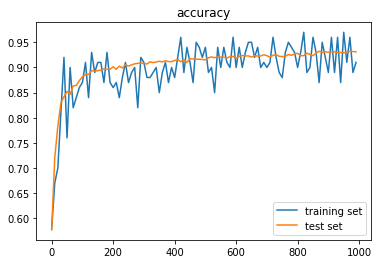

In [25]:
mnist(mode=2)

# 「試してみよう」のその２としてハイパーパラメータ弄りの実施
# 所望パラメータを弄って振る舞いを観察する(以下はデフォルト値のメモ)
    # 重み初期値補正係数
    wieght_init = 0.01 # 変更してみよう
    #入力層サイズ
    input_layer_size = 784 # 変更してみよう
    #中間層サイズ
    hidden_layer_size = 40 # 変更してみよう
    #出力層サイズ
    output_layer_size = 10 # 変更してみよう
    # 繰り返し数
    iters_num = 1000 # 変更してみよう
    # ミニバッチサイズ
    batch_size = 100 # 変更してみよ
    # 学習率
    learning_rate = 0.1 # 変更してみよう
    # 描写頻度
    plot_interval=10

Generation: 10. 正答率(トレーニング) = 0.07
                : 10. 正答率(テスト) = 0.1135
Generation: 20. 正答率(トレーニング) = 0.05
                : 20. 正答率(テスト) = 0.1009
Generation: 30. 正答率(トレーニング) = 0.09
                : 30. 正答率(テスト) = 0.1009
Generation: 40. 正答率(トレーニング) = 0.15
                : 40. 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.09
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.13
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.15
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.1
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.18
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.07
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.08
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.14
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.14
                : 130. 正答率(テスト) = 0.1135
Generation: 140. 正

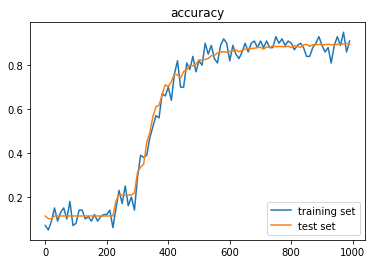

In [26]:
#ハイパーパラメータの変更
#自前の”元に戻す”を実行してからそれぞれを弄ってみる事にする
#まず初期値を大体0に誘導(学習初手で進み具合が悪くなる)
#結果的に指定のイテレーション数では学習が収束しないっぽい
wieght_init = 0.0000001    # 0.01 # 変更してみよう
mnist(mode=0)
wieght_init = 0.01 # 変更してみよう

Generation: 10. 正答率(トレーニング) = 0.09
                : 10. 正答率(テスト) = 0.1031
Generation: 20. 正答率(トレーニング) = 0.08
                : 20. 正答率(テスト) = 0.1031
Generation: 30. 正答率(トレーニング) = 0.11
                : 30. 正答率(テスト) = 0.1399
Generation: 40. 正答率(トレーニング) = 0.34
                : 40. 正答率(テスト) = 0.3661
Generation: 50. 正答率(トレーニング) = 0.43
                : 50. 正答率(テスト) = 0.3888
Generation: 60. 正答率(トレーニング) = 0.43
                : 60. 正答率(テスト) = 0.4186
Generation: 70. 正答率(トレーニング) = 0.54
                : 70. 正答率(テスト) = 0.5564
Generation: 80. 正答率(トレーニング) = 0.55
                : 80. 正答率(テスト) = 0.5595
Generation: 90. 正答率(トレーニング) = 0.67
                : 90. 正答率(テスト) = 0.6922
Generation: 100. 正答率(トレーニング) = 0.71
                : 100. 正答率(テスト) = 0.6684
Generation: 110. 正答率(トレーニング) = 0.62
                : 110. 正答率(テスト) = 0.7249
Generation: 120. 正答率(トレーニング) = 0.76
                : 120. 正答率(テスト) = 0.772
Generation: 130. 正答率(トレーニング) = 0.68
                : 130. 正答率(テスト) = 0.7812
Generation: 140. 正

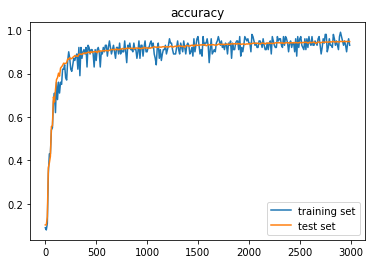

In [27]:
#ハイパーパラメータの変更
#イテレーションを三倍に
#収束はしてくれる&少し性能が上がる
iters_num = 3000    #1000 # 変更してみよう
mnist(mode=0)
iters_num = 1000 # 変更してみよう

Generation: 10. 正答率(トレーニング) = 0.1
                : 10. 正答率(テスト) = 0.0989
Generation: 20. 正答率(トレーニング) = 0.0
                : 20. 正答率(テスト) = 0.098
Generation: 30. 正答率(トレーニング) = 0.0
                : 30. 正答率(テスト) = 0.1863
Generation: 40. 正答率(トレーニング) = 0.0
                : 40. 正答率(テスト) = 0.1967
Generation: 50. 正答率(トレーニング) = 0.2
                : 50. 正答率(テスト) = 0.2063
Generation: 60. 正答率(トレーニング) = 0.3
                : 60. 正答率(テスト) = 0.3664
Generation: 70. 正答率(トレーニング) = 0.2
                : 70. 正答率(テスト) = 0.3695
Generation: 80. 正答率(トレーニング) = 0.5
                : 80. 正答率(テスト) = 0.4331
Generation: 90. 正答率(トレーニング) = 0.3
                : 90. 正答率(テスト) = 0.5258
Generation: 100. 正答率(トレーニング) = 0.5
                : 100. 正答率(テスト) = 0.6453
Generation: 110. 正答率(トレーニング) = 0.3
                : 110. 正答率(テスト) = 0.5506
Generation: 120. 正答率(トレーニング) = 0.5
                : 120. 正答率(テスト) = 0.6379
Generation: 130. 正答率(トレーニング) = 0.6
                : 130. 正答率(テスト) = 0.6508
Generation: 140. 正答率(トレーニング) = 

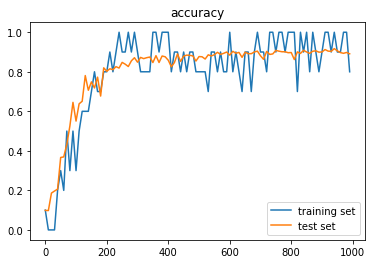

In [28]:
#ハイパーパラメータの変更
#バッチサイズの更新(小さくする)
#学習が荒くなり、かつ収束しにくくなるっぽい
batch_size = 10            #100 # 変更してみよ
mnist(mode=0)
batch_size = 100 # 変更してみよ

Generation: 10. 正答率(トレーニング) = 0.11
                : 10. 正答率(テスト) = 0.0972
Generation: 20. 正答率(トレーニング) = 0.16
                : 20. 正答率(テスト) = 0.0972
Generation: 30. 正答率(トレーニング) = 0.13
                : 30. 正答率(テスト) = 0.0972
Generation: 40. 正答率(トレーニング) = 0.06
                : 40. 正答率(テスト) = 0.0972
Generation: 50. 正答率(トレーニング) = 0.07
                : 50. 正答率(テスト) = 0.0972
Generation: 60. 正答率(トレーニング) = 0.07
                : 60. 正答率(テスト) = 0.0972
Generation: 70. 正答率(トレーニング) = 0.1
                : 70. 正答率(テスト) = 0.0973
Generation: 80. 正答率(トレーニング) = 0.05
                : 80. 正答率(テスト) = 0.0973
Generation: 90. 正答率(トレーニング) = 0.13
                : 90. 正答率(テスト) = 0.0973
Generation: 100. 正答率(トレーニング) = 0.1
                : 100. 正答率(テスト) = 0.0973
Generation: 110. 正答率(トレーニング) = 0.11
                : 110. 正答率(テスト) = 0.0973
Generation: 120. 正答率(トレーニング) = 0.1
                : 120. 正答率(テスト) = 0.0973
Generation: 130. 正答率(トレーニング) = 0.12
                : 130. 正答率(テスト) = 0.0973
Generation: 140. 正答率

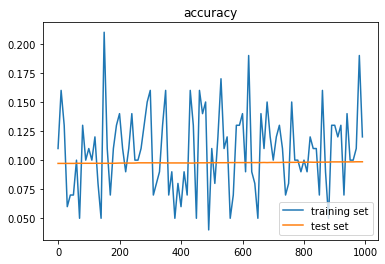

In [29]:
#ハイパーパラメータの変更
#学習率の変更(低くしてみる)
#当然だけど収束しにくくなる(というか全く進まなくなる)
learning_rate = 0.00001 #0.1 # 変更してみよう
mnist(mode=0)

Generation: 10. 正答率(トレーニング) = 0.28
                : 10. 正答率(テスト) = 0.2754
Generation: 20. 正答率(トレーニング) = 0.4
                : 20. 正答率(テスト) = 0.3501
Generation: 30. 正答率(トレーニング) = 0.63
                : 30. 正答率(テスト) = 0.5938
Generation: 40. 正答率(トレーニング) = 0.55
                : 40. 正答率(テスト) = 0.5669
Generation: 50. 正答率(トレーニング) = 0.72
                : 50. 正答率(テスト) = 0.6945
Generation: 60. 正答率(トレーニング) = 0.79
                : 60. 正答率(テスト) = 0.763
Generation: 70. 正答率(トレーニング) = 0.57
                : 70. 正答率(テスト) = 0.6799
Generation: 80. 正答率(トレーニング) = 0.8
                : 80. 正答率(テスト) = 0.8463
Generation: 90. 正答率(トレーニング) = 0.84
                : 90. 正答率(テスト) = 0.845
Generation: 100. 正答率(トレーニング) = 0.87
                : 100. 正答率(テスト) = 0.8798
Generation: 110. 正答率(トレーニング) = 0.83
                : 110. 正答率(テスト) = 0.8441
Generation: 120. 正答率(トレーニング) = 0.9
                : 120. 正答率(テスト) = 0.8791
Generation: 130. 正答率(トレーニング) = 0.78
                : 130. 正答率(テスト) = 0.8856
Generation: 140. 正答率(ト

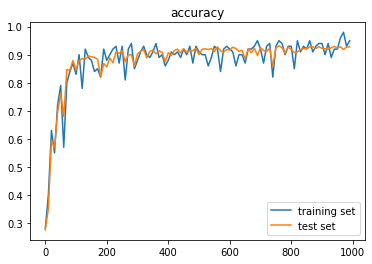

In [30]:
#ハイパーパラメータの変更
#学習率の変更(高くしてみる)
#このくらいならばよい結果を招く？
learning_rate = 1 #0.1 # 変更してみよう
mnist(mode=0)

Generation: 10. 正答率(トレーニング) = 0.12
                : 10. 正答率(テスト) = 0.1135
Generation: 20. 正答率(トレーニング) = 0.11
                : 20. 正答率(テスト) = 0.0981
Generation: 30. 正答率(トレーニング) = 0.12
                : 30. 正答率(テスト) = 0.0981
Generation: 40. 正答率(トレーニング) = 0.1
                : 40. 正答率(テスト) = 0.0982
Generation: 50. 正答率(トレーニング) = 0.09
                : 50. 正答率(テスト) = 0.1032
Generation: 60. 正答率(トレーニング) = 0.08
                : 60. 正答率(テスト) = 0.0892
Generation: 70. 正答率(トレーニング) = 0.14
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.09
                : 80. 正答率(テスト) = 0.098
Generation: 90. 正答率(トレーニング) = 0.12
                : 90. 正答率(テスト) = 0.098
Generation: 100. 正答率(トレーニング) = 0.1
                : 100. 正答率(テスト) = 0.098
Generation: 110. 正答率(トレーニング) = 0.12
                : 110. 正答率(テスト) = 0.098
Generation: 120. 正答率(トレーニング) = 0.08
                : 120. 正答率(テスト) = 0.101
Generation: 130. 正答率(トレーニング) = 0.12
                : 130. 正答率(テスト) = 0.101
Generation: 140. 正答率(トレーニ

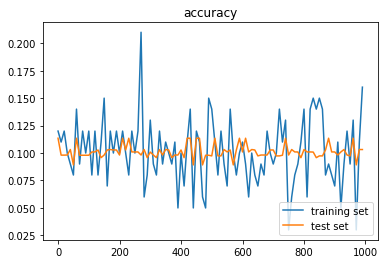

In [31]:
#ハイパーパラメータの変更
#学習率の変更(さらに高くしてみる)
#発散気味(やりすぎは良くないという事で)
learning_rate = 100 #0.1 # 変更してみよう
mnist(mode=0)
learning_rate = 0.1 # 変更してみよう

Generation: 10. 正答率(トレーニング) = 0.14
                : 10. 正答率(テスト) = 0.0971
Generation: 20. 正答率(トレーニング) = 0.13
                : 20. 正答率(テスト) = 0.1172
Generation: 30. 正答率(トレーニング) = 0.09
                : 30. 正答率(テスト) = 0.1753
Generation: 40. 正答率(トレーニング) = 0.15
                : 40. 正答率(テスト) = 0.1819
Generation: 50. 正答率(トレーニング) = 0.24
                : 50. 正答率(テスト) = 0.2404
Generation: 60. 正答率(トレーニング) = 0.27
                : 60. 正答率(テスト) = 0.2761
Generation: 70. 正答率(トレーニング) = 0.3
                : 70. 正答率(テスト) = 0.3271
Generation: 80. 正答率(トレーニング) = 0.37
                : 80. 正答率(テスト) = 0.3396
Generation: 90. 正答率(トレーニング) = 0.43
                : 90. 正答率(テスト) = 0.3664
Generation: 100. 正答率(トレーニング) = 0.42
                : 100. 正答率(テスト) = 0.4211
Generation: 110. 正答率(トレーニング) = 0.43
                : 110. 正答率(テスト) = 0.4655
Generation: 120. 正答率(トレーニング) = 0.48
                : 120. 正答率(テスト) = 0.5386
Generation: 130. 正答率(トレーニング) = 0.63
                : 130. 正答率(テスト) = 0.6077
Generation: 140. 正

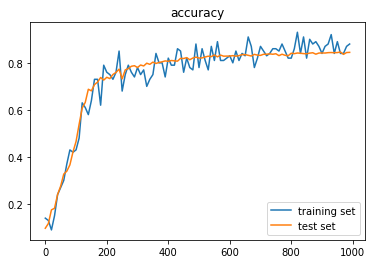

In [32]:
#最後にネットワークそのものの変更だけど
#入力層は画素数に合わせないとダメなので変更なしとする
#出力層はラベル数に合わせないとダメ(要するに0から9の数字分類モデルだから)なのでこれも変更なし
#ということでいじれる余地は中間層の構成くらいかもしれずで実験してみる
#まずは貧弱にしてみる
#やはり性能は落ちる
hidden_layer_size = 4 #40 # 変更してみよう
mnist(mode=0)

Generation: 10. 正答率(トレーニング) = 0.31
                : 10. 正答率(テスト) = 0.3009
Generation: 20. 正答率(トレーニング) = 0.29
                : 20. 正答率(テスト) = 0.3126
Generation: 30. 正答率(トレーニング) = 0.53
                : 30. 正答率(テスト) = 0.5861
Generation: 40. 正答率(トレーニング) = 0.51
                : 40. 正答率(テスト) = 0.4915
Generation: 50. 正答率(トレーニング) = 0.56
                : 50. 正答率(テスト) = 0.5774
Generation: 60. 正答率(トレーニング) = 0.79
                : 60. 正答率(テスト) = 0.7487
Generation: 70. 正答率(トレーニング) = 0.62
                : 70. 正答率(テスト) = 0.6389
Generation: 80. 正答率(トレーニング) = 0.79
                : 80. 正答率(テスト) = 0.7749
Generation: 90. 正答率(トレーニング) = 0.87
                : 90. 正答率(テスト) = 0.7897
Generation: 100. 正答率(トレーニング) = 0.77
                : 100. 正答率(テスト) = 0.8071
Generation: 110. 正答率(トレーニング) = 0.73
                : 110. 正答率(テスト) = 0.8129
Generation: 120. 正答率(トレーニング) = 0.85
                : 120. 正答率(テスト) = 0.8308
Generation: 130. 正答率(トレーニング) = 0.79
                : 130. 正答率(テスト) = 0.8424
Generation: 140. 

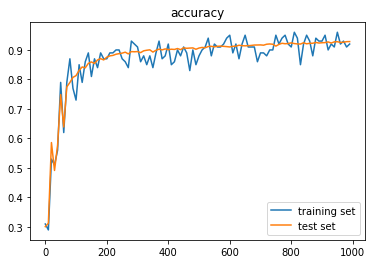

In [33]:
#最後にネットワークそのものの変更だけど
#中間層をリッチにしてみる
#少しだけ学習の収束点が早まるかもしれず
#&少しだけ各イテレーションでの学習とテストの誤差が減る?
hidden_layer_size = 240 #40 # 変更してみよう
mnist(mode=0)

Generation: 10. 正答率(トレーニング) = 0.37
                : 10. 正答率(テスト) = 0.3777
Generation: 20. 正答率(トレーニング) = 0.52
                : 20. 正答率(テスト) = 0.5634
Generation: 30. 正答率(トレーニング) = 0.68
                : 30. 正答率(テスト) = 0.6894
Generation: 40. 正答率(トレーニング) = 0.72
                : 40. 正答率(テスト) = 0.7454
Generation: 50. 正答率(トレーニング) = 0.8
                : 50. 正答率(テスト) = 0.7851
Generation: 60. 正答率(トレーニング) = 0.77
                : 60. 正答率(テスト) = 0.8056
Generation: 70. 正答率(トレーニング) = 0.78
                : 70. 正答率(テスト) = 0.8247
Generation: 80. 正答率(トレーニング) = 0.78
                : 80. 正答率(テスト) = 0.8297
Generation: 90. 正答率(トレーニング) = 0.81
                : 90. 正答率(テスト) = 0.8388
Generation: 100. 正答率(トレーニング) = 0.87
                : 100. 正答率(テスト) = 0.8503
Generation: 110. 正答率(トレーニング) = 0.86
                : 110. 正答率(テスト) = 0.8611
Generation: 120. 正答率(トレーニング) = 0.81
                : 120. 正答率(テスト) = 0.8615
Generation: 130. 正答率(トレーニング) = 0.87
                : 130. 正答率(テスト) = 0.8631
Generation: 140. 正

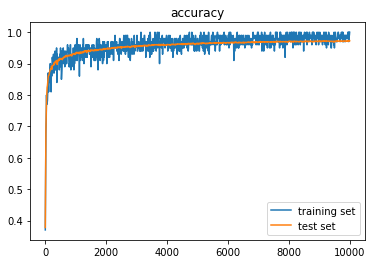

In [34]:
#追試で性能向上っぽいことも
#交差検証したいけど時間かかりそうなのでエイやで
#まぁ偶々だけど100%に近い数字が出てはいる
#過学習と言われるかもしれず
#この数字が良きか如何かはコメントしない

# 重み初期値補正係数
wieght_init = 0.1   #0.01 # 変更してみよう
#中間層サイズ
hidden_layer_size = 80 # 変更してみよう
# 繰り返し数
iters_num = 10000 # 変更してみよう
# 学習率
learning_rate = 0.1 # 変更してみよう

mnist(mode=0)